In [398]:
import torch
import torchvision
import torchvision.transforms.functional as vision_F
import matplotlib.pyplot as plt


cifar10_dataset = torchvision.datasets.CIFAR10('dataset', download=True)

Files already downloaded and verified


In [399]:
img = cifar10_dataset[0][0]
img = vision_F.pil_to_tensor(img)

In [737]:
def Cutout(img, v):  # [0, 60] => percentage: [0, 0.2]
    if v <= 0.:
        return img

    c, w, h = img.shape
    
    v = v * min(w, h)
    
    x0 = int(torch.rand(1).item() * w)
    y0 = int(torch.rand(1).item() * h)

    x0 = round(max(0, x0 - int(v / 2.)))
    y0 = round(max(0, y0 - int(v / 2.)))
    x1 = round(min(w, x0 + v))
    y1 = round(min(h, y0 + v))
    
    color = (125, 123, 114)
    new_img = img.clone()
    new_img[:, x0:x1, y0:y1] = torch.tensor(color, dtype=torch.uint8).unsqueeze(1).unsqueeze(2)
    return new_img

Cutout(img, 0.2)


affine = torchvision.transforms.RandomAffine(
    degrees=(-0, 0),
    # translate=(0.1, 0.1),
    shear=(-20, 20, -20, 20),
)

# color = torchvision.transforms.RandomPerspective(distortion_scale=0.3, p=1)
# color = torchvision.transforms.ColorJitter(0.8*.5, 0.8*.5, 0.8*.5, 0.2*.5)

auto_contrast = vision_F.autocontrast # {0, 1}
posterize = vision_F.posterize(img, 4) # [1, 8]
cutout = Cutout(img, 0.2) # [0, 0.2]

# rotation 5 *
# shear 5 *
# auto_contrast 5 *
# posterize 5 *

# brightness 5 *
# saturation 5 *
# contrast 5 *
# hue 5 *
# color permutations 24 *

In [771]:
vision_F.posterize(img, 4.5)

tensor([[[ 49,  33,  48,  ..., 148, 144, 148],
         [ 16,   0,  16,  ..., 113, 117, 112],
         [ 17,  16,  49,  ..., 116, 112, 101],
         ...,
         [208, 193, 196,  ..., 160,  48,  53],
         [180, 165, 176,  ..., 176,  97,  81],
         [177, 160, 177,  ..., 208, 149, 113]],

        [[ 52,  36,  48,  ..., 132, 117, 116],
         [ 20,   0,   0,  ...,  80,  81,  85],
         [ 16,   5,  17,  ...,  84,  84,  65],
         ...,
         [160, 145, 161,  ..., 133,  21,  32],
         [129, 113, 144,  ..., 148,  52,  53],
         [144, 129, 132,  ..., 176, 116,  84]],

        [[ 53,  37,  33,  ..., 100, 100, 101],
         [ 20,   0,   0,  ...,  53,  48,  49],
         [ 21,   0,   0,  ...,  48,  48,  32],
         ...,
         [ 96,  32,  16,  ...,  68,   5,  20],
         [ 96,  32,  20,  ...,  84,  32,  32],
         [116,  84,  85,  ..., 132,  84,  64]]], dtype=torch.uint8)

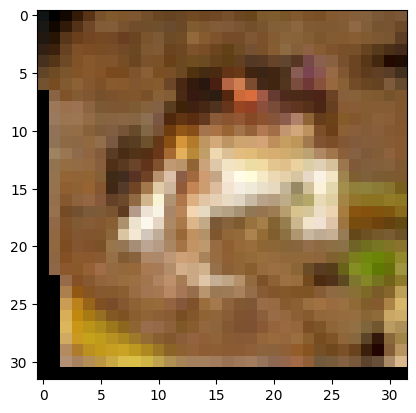

In [769]:
# plt.imshow(img.permute(1,2,0))
# plt.show()
plt.imshow(affine(img).permute(1,2,0))
# plt.imshow(auto_contrast(img).permute(1,2,0))
# plt.imshow(F.posterize(img, 1).permute(1,2,0))
plt.show()

In [ ]:
(auto_contrast(img) == img).sum() / img.sum()

tensor(0.0058)

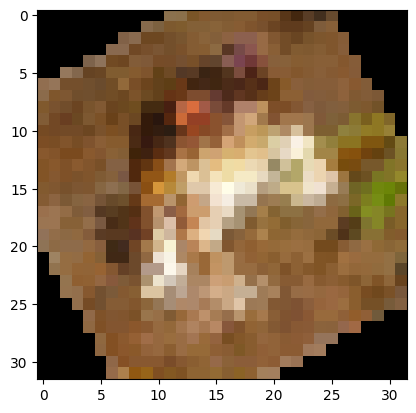

In [215]:
plt.imshow(F.rotate(img, 30).permute(1,2,0))

tensor([[[ 59,  43,  50,  ..., 158, 152, 148],
         [ 16,   0,  18,  ..., 123, 119, 122],
         [ 25,  16,  49,  ..., 118, 120, 109],
         ...,
         [208, 201, 198,  ..., 160,  56,  53],
         [180, 173, 186,  ..., 184,  97,  83],
         [177, 168, 179,  ..., 216, 151, 123]],

        [[ 62,  46,  48,  ..., 132, 125, 124],
         [ 20,   0,   8,  ...,  88,  83,  87],
         [ 24,   7,  27,  ...,  84,  84,  73],
         ...,
         [170, 153, 161,  ..., 133,  31,  34],
         [139, 123, 144,  ..., 148,  62,  53],
         [144, 129, 142,  ..., 184, 118,  92]],

        [[ 63,  45,  43,  ..., 108, 102, 103],
         [ 20,   0,   0,  ...,  55,  50,  57],
         [ 21,   0,   8,  ...,  50,  50,  42],
         ...,
         [ 96,  34,  26,  ...,  70,   7,  20],
         [ 96,  42,  30,  ...,  94,  34,  34],
         [116,  94,  87,  ..., 140,  84,  72]]], dtype=torch.uint8)

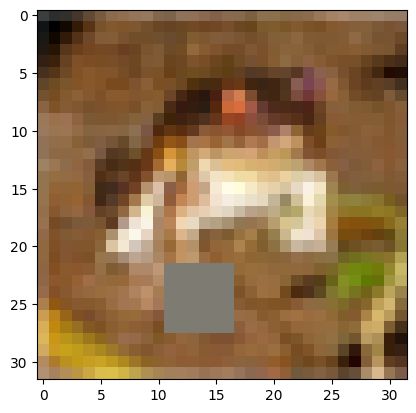

In [369]:
img = cifar10_dataset[0][0]
img = F.pil_to_tensor(img)
plt.imshow(Cutout(img, 0.2).permute(1,2,0))

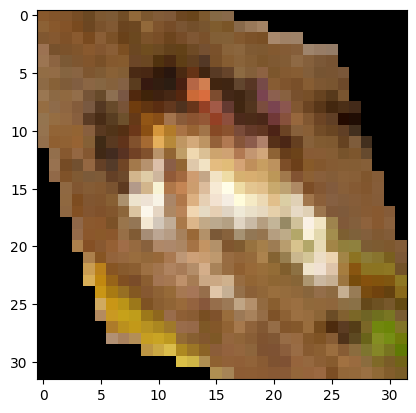

In [522]:
trans_x = torch.randint(-10, 10, size=(1,))
trans_y = torch.randint(-10, 10, size=(1,))

new_img = vision_F.affine(
    img,
    angle=0,
    translate=(0, 0),
    scale=1,
    shear=(-20, -20),
)

plt.imshow(new_img.permute(1,2,0))